In [1]:
import os
import io
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
import easygui
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import time
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint

In [2]:
def fetch_stock_data(stock_name):
    end_date = int(datetime.now().timestamp())
    start_date = int((datetime.now() - pd.DateOffset(days=1826)).timestamp())

    url = f"https://query1.finance.yahoo.com/v7/finance/download/{stock_name}?period1={start_date}&period2={end_date}&interval=1d&events=history"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36"
    }

    retries = 3
    while retries > 0:
        try:
            response = requests.get(url, headers=headers)
            if response.status_code == 200:
                stock_data = pd.read_csv(io.StringIO(response.text))
                return stock_data
            else:
                print("Failed to fetch data")
                print(f"Status Code: {response.status_code}")
                return None
        except requests.RequestException as e:
            print(f"Request failed: {e}")
            retries -= 1
            time.sleep(2)  # Wait before retrying

    print("Maximum retries exceeded. Unable to fetch data.")
    return None
def save_to_excel(stock_data, stock_name):
    if stock_data is not None:
        stock_data.to_excel(f"Historical Data/{stock_name}.xlsx", index=False)
        print(f"Stock data for {stock_name} saved successfully to the Excel file.")

In [3]:

easygui.msgbox("Welcome to Our project \n Stock Price Prediction Using LSTM\n Raghav Arora 220370\nViresh Chauhan 220422", "Stock Prediction Using LSTM")
stock_name=easygui.enterbox('Please enter a stock ticker symbol')

In [4]:
def data_analysis():
    df=pd.read_excel(f"Historical Data/{stock_name}.xlsx")
    df.describe()
    df.info()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)  # Set 'Date' column as the index

    # Plotting
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.plot(df['Adj Close'])
    plt.ylabel('Adj Close')
    plt.xlabel('Date')
    plt.title(f'Closing Price of {stock_name}')
    plt.show()
    df['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel('Date')
    plt.title(f"Sales Volume for {stock_name}")
    plt.show()
    df_daily_return = df['Adj Close'].pct_change()
    df_daily_return
    df_daily_return.plot( legend=True, linestyle='--', marker='o')
    plt.show()
    df_daily_return.hist(bins=50)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{stock_name}')
    plt.show()


    moving_avg = pd.read_excel(f"Historical Data/{stock_name}.xlsx")

    ma_day = [10, 20, 50]

    for ma in ma_day:
        column_name = f"MA for {ma} days"
        moving_avg[column_name] = moving_avg['Adj Close'].rolling(ma).mean()

    fig, axes = plt.subplots(nrows=1, ncols=1)
    fig.set_figheight(8)
    fig.set_figwidth(12)

    moving_avg[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes)
    axes.set_title(f'Stock Analysis for {stock_name}')

    # Adjust spacing between subplots here
    plt.subplots_adjust(wspace=0.3, hspace=0.3)  # You can modify these values as needed

    plt.show()
    closing_df = pd.read_excel(f"Historical Data/{stock_name}.xlsx")
    column_name = 'Adj Close'
    closing_df[column_name] = closing_df['Adj Close']
    closing_df['Adj Close'] = pd.to_numeric(closing_df['Adj Close'], errors='coerce')
    closing_df.dropna(subset=['Adj Close'], inplace=True)

    tech_return = closing_df['Adj Close'].pct_change()
    rets = tech_return.dropna()

    area = np.pi * 20

    plt.figure(figsize=(10, 8))
    plt.scatter(rets.mean(), rets.std(), s=area)
    plt.xlabel('Expected return')
    plt.ylabel('Risk')

    plt.annotate(rets.name, xy=(rets.mean(), rets.std()), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom',
                arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))
    plt.show()


In [5]:
def data_scaling(raw_data):
        scaled_data = raw_data.values.reshape(-1, 1)
        scaler=MinMaxScaler(feature_range=(0,1))
        scaled_data=scaler.fit_transform(scaled_data)
        train_dataset_len=int(np.ceil(len(scaled_data)*.80))
        train_data= scaled_data[: train_dataset_len]
        test_data=raw_data[ train_dataset_len-60:].values
        features_set = []
        labels = []
        for i in range(60, len(train_data)):
            features_set.append(train_data[i-60:i, 0])
            labels.append(train_data[i, 0])
        features_set, labels = np.array(features_set), np.array(labels)
        features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
        return features_set,labels

In [6]:
def create_lstm_model(features_set):
            model = Sequential()
            model.add(LSTM(units=128, return_sequences=True, input_shape=(features_set.shape[1], 1)))
            model.add(Dropout(0.65))
            model.add(LSTM(units=64, return_sequences=True))
            model.add(Dropout(0.40))
            model.add(LSTM(units=64, return_sequences=True))
            model.add(Dropout(0.40))
            model.add(LSTM(units=32))
            model.add(Dropout(0.40))
            model.add(Dense(units=1))
            model.compile(optimizer='adam', loss='mean_squared_error')
            return model

In [7]:
def model_performance_analysis(model,features_set,labels,history):
            from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
            predictions = model.predict(features_set)
            mse = mean_squared_error(labels, predictions)
            mae = mean_absolute_error(labels, predictions)
            r2 = r2_score(labels, predictions)
            print(f'Mean Squared Error: {mse}')
            print(f'Mean Absolute Error: {mae}')
            print(f'R-squared Score: {r2}') 
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('Model Loss') 
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend(['Train', 'Validation'], loc='upper right')
            plt.show()

In [8]:
def model_training():        
        raw_data=pd.read_excel(f'Historical Data/{stock_name}.xlsx')['Adj Close']
        features_set,labels= data_scaling(raw_data)

        # Create the LSTM model
        model = create_lstm_model(features_set)

        validation_split = 0.2 
        split_index = int(len(features_set) * (1 - validation_split))
        train_features, val_features = features_set[:split_index], features_set[split_index:]
        train_labels, val_labels = labels[:split_index], labels[split_index:]

        mc = ModelCheckpoint(f'Models/LSTM({stock_name}).hdf5', monitor='loss', verbose=1, save_best_only=True, mode='min')
        # Train the model
        history = model.fit(train_features,train_labels, epochs=700, batch_size=192,callbacks=[mc],validation_data=(val_features, val_labels))
        model_performance_analysis(model,features_set,labels,history)


In [9]:
def predictions(n):
        model=load_model(f'Models/LSTM({stock_name}).hdf5')
        df=pd.read_excel(f'Historical Data/{stock_name}.xlsx')
        data=df.filter(['Adj Close'])
        scaled_data = data.values.reshape(-1, 1)
        scaler=MinMaxScaler(feature_range=(0,1))
        scaled_data=scaler.fit_transform(scaled_data)
        train_dataset_len=int(np.ceil(len(scaled_data)*.85))
        test_data = scaled_data[train_dataset_len - 60: , :]
        x_test = []
        x_test.append(test_data[-60:])
        x_test = np.array(x_test)
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        predictions = []
        for _ in range(n):
                # Predict the next day
                prediction = model.predict(x_test)
                
                # Append the prediction to the results
                predictions.append(prediction[0, 0])

                # Update x_test for the next prediction
                x_test = np.roll(x_test, -1, axis=1)
                x_test[0, -1, 0] = prediction
        # Inverse transform the predictions to get actual stock prices
        predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
        plt.plot(predictions)
        plt.xlabel("Number Of Days")
        plt.ylabel("Stock Price")
        plt.show  
        easygui.msgbox( predictions, "Prediction for the next days")  
  


Stock data for MSFT saved successfully to the Excel file.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


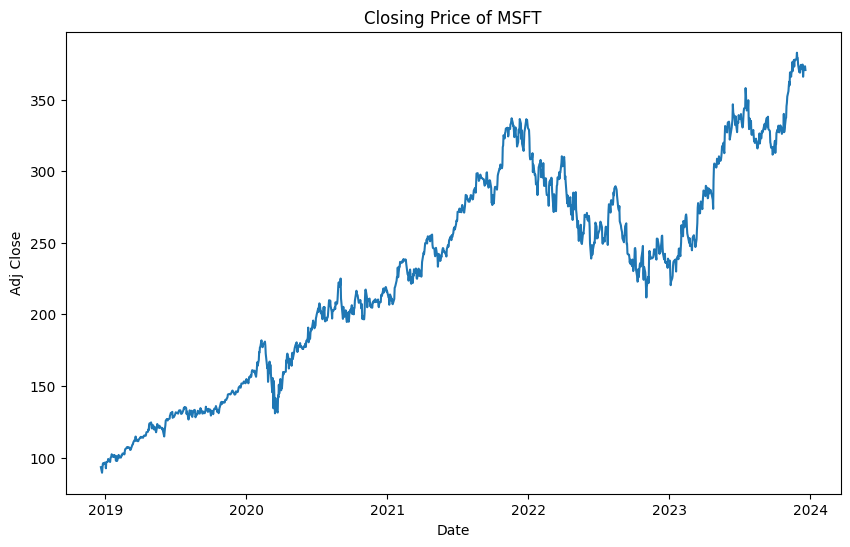

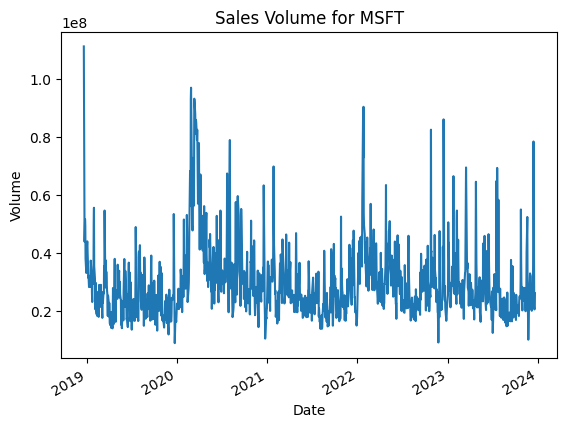

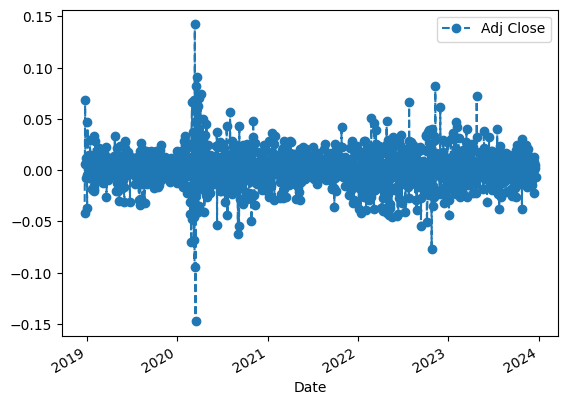

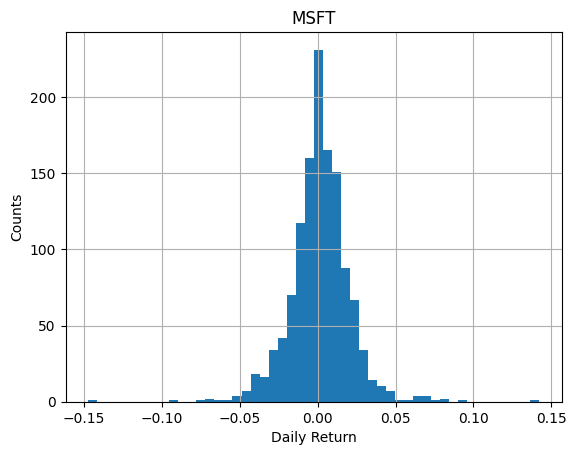

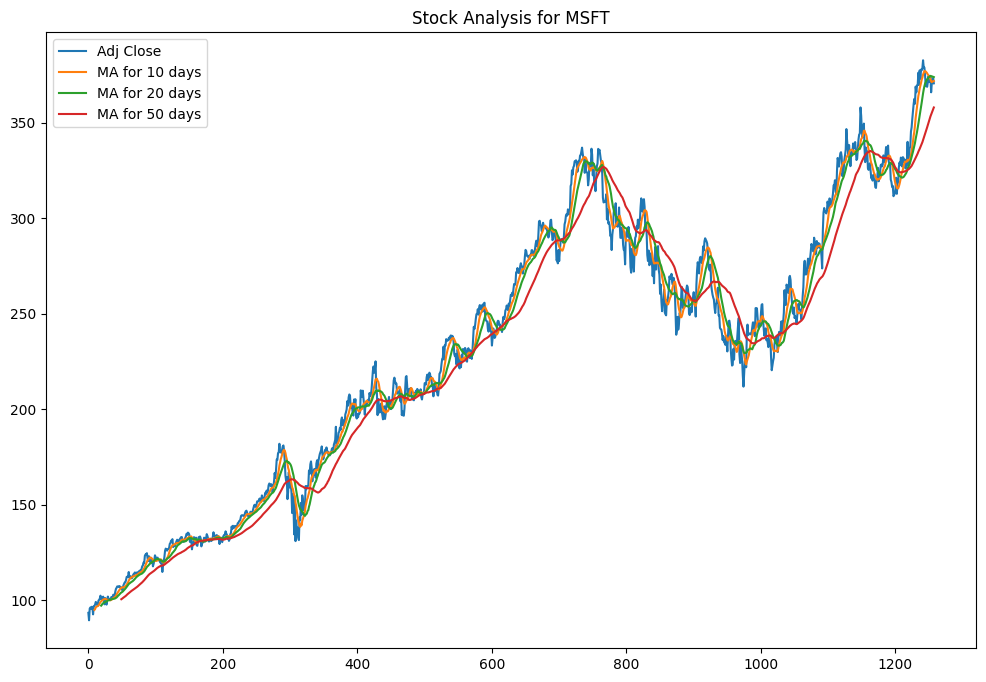

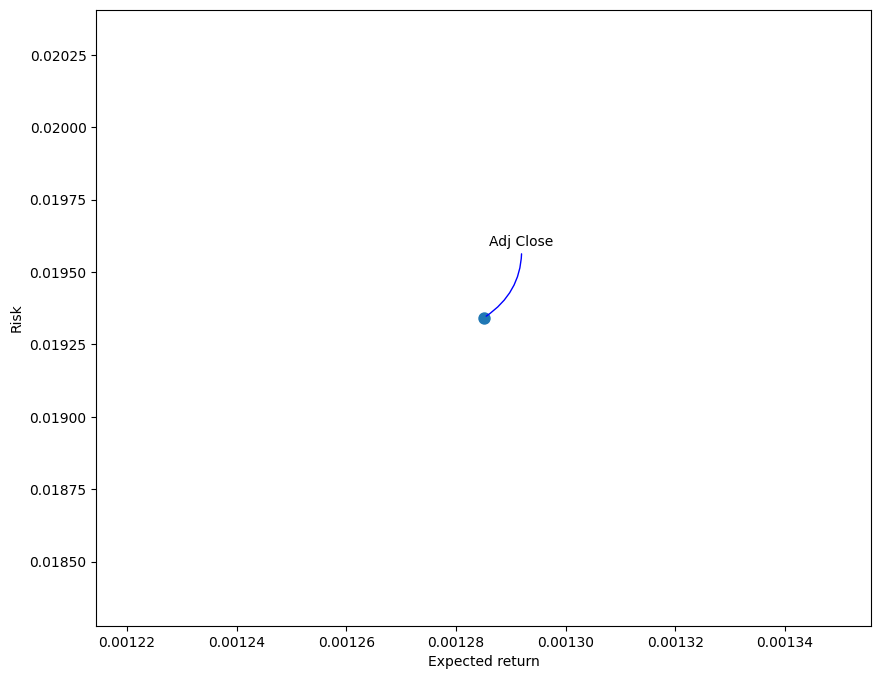



Epoch 1/700

4/4 [==============================] - ETA: 0s - loss: 0.1111
Epoch 1: loss improved from inf to 0.11112, saving model to Models\LSTM(MSFT).hdf5
4/4 [==============================] - 8s 705ms/step - loss: 0.1111 - val_loss: 0.0379
Epoch 2/700


c:\Users\nisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.0352
Epoch 2: loss improved from 0.11112 to 0.03522, saving model to Models\LSTM(MSFT).hdf5
4/4 [==============================] - 1s 297ms/step - loss: 0.0352 - val_loss: 0.0177
Epoch 3/700
4/4 [==============================] - ETA: 0s - loss: 0.0297
Epoch 3: loss improved from 0.03522 to 0.02968, saving model to Models\LSTM(MSFT).hdf5
4/4 [==============================] - 1s 276ms/step - loss: 0.0297 - val_loss: 0.0346
Epoch 4/700
4/4 [==============================] - ETA: 0s - loss: 0.0223
Epoch 4: loss improved from 0.02968 to 0.02235, saving model to Models\LSTM(MSFT).hdf5
4/4 [==============================] - 1s 244ms/step - loss: 0.0223 - val_loss: 0.0027
Epoch 5/700
4/4 [==============================] - ETA: 0s - loss: 0.0214
Epoch 5: loss improved from 0.02235 to 0.02138, saving model to Models\LSTM(MSFT).hdf5
4/4 [==============================] - 1s 232ms/step - loss: 0.0214 - val_loss: 0.0040
Epoch 6/700
4/4 [===

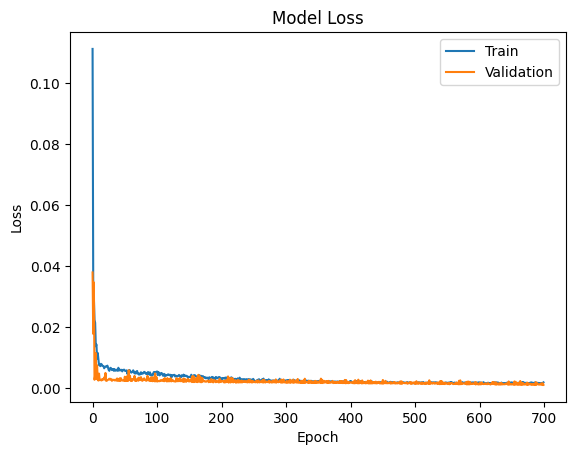

1/1 [==============================] - ETA: 0s

C:\Users\nisha\AppData\Local\Temp\ipykernel_21876\1065001453.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_test[0, -1, 0] = prediction


1/1 [==============================] - 0s 26ms/step


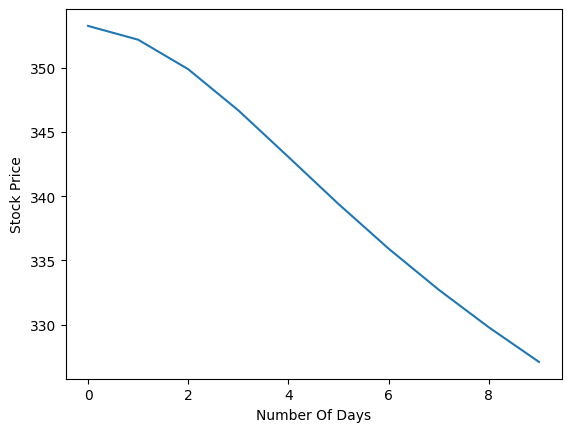

In [10]:
if(os.path.isfile(f'Models/LSTM({stock_name}).hdf5') and os.path.isfile(f'Historical Data/{stock_name}.xlsx')):
    x=easygui.boolbox("A model for this stock is found do you wish to use that(yes) or create a new model(no)" ,'' ,('Continue with the previous model', 'Create a new model'))
    if(x):
        data_analysis()
        n=easygui.integerbox("Enter the number of days you would like to predict the data for: ")
        predictions(n)
    else:
        data = fetch_stock_data(stock_name)
        if data is not None:
            save_to_excel(data, stock_name)
        else:
            print("Data retrieval failed or invalid ticker symbol provided.")
        data_analysis()
        model_training()
        n=easygui.integerbox("Enter the number of days you would like to predict the data for: ")
        predictions(n)
else:
    data = fetch_stock_data(stock_name)
    if data is not None:
        save_to_excel(data, stock_name)
    else:
        print("Data retrieval failed or invalid ticker symbol provided.")
    data_analysis()
    model_training()
    n=easygui.integerbox("Enter the number of days you would like to predict the data for: ")
    predictions(n)